Raw data shape: (1258, 20)
Column structure: <class 'pandas.core.indexes.multi.MultiIndex'>
MultiIndex columns detected
Level 0 columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Level 1 columns: ['AAPL', 'AMZN', 'GOOGL', 'MSFT']
Using 'Close' prices (Adj Close not available)
Final price data shape: (1258, 4)
Final columns: ['AAPL', 'AMZN', 'GOOGL', 'MSFT']

Returns data shape: (1257, 4)
Sample of returns data:
                AAPL      AMZN     GOOGL      MSFT
Date                                              
2020-01-03 -0.009722 -0.012139 -0.005232 -0.012451
2020-01-06  0.007968  0.014886  0.026654  0.002585
2020-01-07 -0.004703  0.002092 -0.001932 -0.009117
2020-01-08  0.016086 -0.007809  0.007118  0.015928
2020-01-09  0.021241  0.004799  0.010498  0.012493

Mean returns (daily):
AAPL: 0.0012
AMZN: 0.0009
GOOGL: 0.0010
MSFT: 0.0010

Optimizing for minimum volatility...

MINIMUM VOLATILITY PORTFOLIO
AAPL: 32.47%
AMZN: 12.72%
GOOGL: 23.76%
MSFT: 31.05%

Expected Annual Return: 26.48

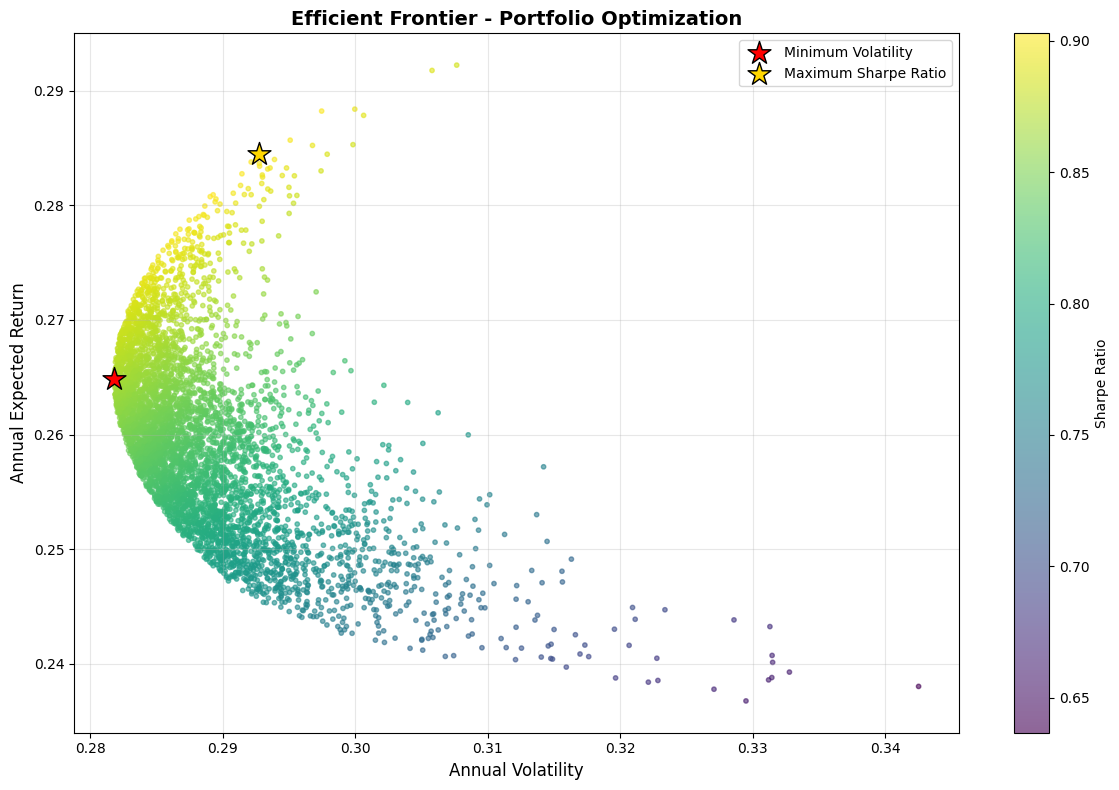


INDIVIDUAL STOCK PERFORMANCE
AAPL: Return=29.79%, Volatility=31.68%, Sharpe=0.877
AMZN: Return=23.27%, Volatility=35.96%, Sharpe=0.591
GOOGL: Return=25.76%, Volatility=32.50%, Sharpe=0.731
MSFT: Return=24.89%, Volatility=30.50%, Sharpe=0.751


In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load data with robust error handling
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']

def get_stock_data(tickers, start_date='2020-01-01', end_date='2025-01-01'):
    """
    Robust function to download stock data and extract adjusted close prices
    """
    try:
        # Download data
        data = yf.download(tickers, start=start_date, end=end_date, progress=False)
        
        if data.empty:
            raise ValueError("No data downloaded")
        
        print("Raw data shape:", data.shape)
        print("Column structure:", type(data.columns))
        
        # Handle different data structures
        if isinstance(data.columns, pd.MultiIndex):
            print("MultiIndex columns detected")
            print("Level 0 columns:", data.columns.get_level_values(0).unique().tolist())
            print("Level 1 columns:", data.columns.get_level_values(1).unique().tolist())
            
            # Try to get Adj Close, fallback to Close
            if 'Adj Close' in data.columns.get_level_values(0):
                price_data = data['Adj Close']
                print("Using 'Adj Close' prices")
            elif 'Close' in data.columns.get_level_values(0):
                price_data = data['Close']
                print("Using 'Close' prices (Adj Close not available)")
            else:
                # Use the first available price column
                available_cols = data.columns.get_level_values(0).unique().tolist()
                price_col = available_cols[0]
                price_data = data[price_col]
                print(f"Using '{price_col}' prices")
        else:
            # Single level columns
            print("Single level columns detected")
            print("Available columns:", data.columns.tolist())
            
            if len(tickers) == 1:
                # Single ticker case
                price_data = data
            else:
                # This shouldn't happen with multiple tickers, but handle it
                price_data = data
        
        # Ensure we have a DataFrame with proper column names
        if isinstance(price_data, pd.Series):
            price_data = price_data.to_frame(name=tickers[0])
        
        # Clean column names if needed
        price_data.columns = [col.replace(' ', '_') if isinstance(col, str) else col for col in price_data.columns]
        
        print(f"Final price data shape: {price_data.shape}")
        print(f"Final columns: {price_data.columns.tolist()}")
        
        return price_data
        
    except Exception as e:
        print(f"Error downloading data: {e}")
        # Fallback: download individual stocks
        print("Trying individual downloads...")
        price_data = pd.DataFrame()
        
        for ticker in tickers:
            try:
                stock = yf.download(ticker, start=start_date, end=end_date, progress=False)
                if 'Adj Close' in stock.columns:
                    price_data[ticker] = stock['Adj Close']
                else:
                    price_data[ticker] = stock['Close']
                print(f"Successfully downloaded {ticker}")
            except Exception as e2:
                print(f"Failed to download {ticker}: {e2}")
        
        return price_data

# Download the data
data = get_stock_data(tickers)

if data.empty:
    raise ValueError("Could not download any stock data")

# Calculate returns
returns = data.pct_change().dropna()
print(f"\nReturns data shape: {returns.shape}")
print("Sample of returns data:")
print(returns.head())

# Step 2: Calculate mean returns and covariance
mean_returns = returns.mean()
cov_matrix = returns.cov()

print(f"\nMean returns (daily):")
for i, ticker in enumerate(returns.columns):
    print(f"{ticker}: {mean_returns.iloc[i]:.4f}")

# Step 3: Define portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    """
    Calculate portfolio return and volatility
    """
    ret = np.dot(weights, mean_returns) * 252  # annualized
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))  # annualized
    return ret, vol

# Step 4: Define objective (minimize volatility)
def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# Step 5: Optimization setup
num_assets = len(returns.columns)
init_guess = num_assets * [1. / num_assets]
bounds = tuple((0, 1) for _ in range(num_assets))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Optimize for minimum volatility
print("\nOptimizing for minimum volatility...")
opt = minimize(minimize_volatility, init_guess,
               args=(mean_returns, cov_matrix),
               method='SLSQP', bounds=bounds, constraints=constraints)

# Step 6: Results
if opt.success:
    opt_weights = opt.x
    ret, vol = portfolio_performance(opt_weights, mean_returns, cov_matrix)
    
    print("\n" + "="*50)
    print("MINIMUM VOLATILITY PORTFOLIO")
    print("="*50)
    for i, ticker in enumerate(returns.columns):
        print(f"{ticker}: {opt_weights[i]:.2%}")
    print(f"\nExpected Annual Return: {ret:.2%}")
    print(f"Expected Annual Volatility: {vol:.2%}")
    print(f"Sharpe Ratio (assuming 2% risk-free rate): {(ret - 0.02) / vol:.3f}")
else:
    print("Optimization failed:", opt.message)

# Additional analysis: Maximum Sharpe ratio portfolio
def maximize_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(ret - risk_free_rate) / vol  # Negative because we're minimizing

print("\nOptimizing for maximum Sharpe ratio...")
opt_sharpe = minimize(maximize_sharpe, init_guess,
                     args=(mean_returns, cov_matrix),
                     method='SLSQP', bounds=bounds, constraints=constraints)

if opt_sharpe.success:
    opt_weights_sharpe = opt_sharpe.x
    ret_sharpe, vol_sharpe = portfolio_performance(opt_weights_sharpe, mean_returns, cov_matrix)
    
    print("\n" + "="*50)
    print("MAXIMUM SHARPE RATIO PORTFOLIO")
    print("="*50)
    for i, ticker in enumerate(returns.columns):
        print(f"{ticker}: {opt_weights_sharpe[i]:.2%}")
    print(f"\nExpected Annual Return: {ret_sharpe:.2%}")
    print(f"Expected Annual Volatility: {vol_sharpe:.2%}")
    print(f"Sharpe Ratio: {(ret_sharpe - 0.02) / vol_sharpe:.3f}")

# Visualization: Efficient Frontier
def generate_random_portfolios(mean_returns, cov_matrix, num_portfolios=5000):
    """
    Generate random portfolios for efficient frontier visualization
    """
    results = np.zeros((3, num_portfolios))
    
    for i in range(num_portfolios):
        # Generate random weights
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)  # Normalize to sum to 1
        
        # Calculate portfolio performance
        portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0, i] = portfolio_return
        results[1, i] = portfolio_volatility
        results[2, i] = (portfolio_return - 0.02) / portfolio_volatility  # Sharpe ratio
    
    return results

print("\nGenerating efficient frontier...")
results = generate_random_portfolios(mean_returns, cov_matrix)

# Create the plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(results[1, :], results[0, :], c=results[2, :], 
                     cmap='viridis', alpha=0.6, s=10)
plt.colorbar(scatter, label='Sharpe Ratio')

# Add optimal portfolios
if opt.success:
    plt.scatter(vol, ret, marker='*', color='red', s=300, 
               label='Minimum Volatility', edgecolors='black', linewidth=1)

if opt_sharpe.success:
    plt.scatter(vol_sharpe, ret_sharpe, marker='*', color='gold', s=300, 
               label='Maximum Sharpe Ratio', edgecolors='black', linewidth=1)

plt.xlabel('Annual Volatility', fontsize=12)
plt.ylabel('Annual Expected Return', fontsize=12)
plt.title('Efficient Frontier - Portfolio Optimization', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Individual stock performance for comparison
print("\n" + "="*50)
print("INDIVIDUAL STOCK PERFORMANCE")
print("="*50)
for i, ticker in enumerate(returns.columns):
    annual_return = mean_returns.iloc[i] * 252
    annual_vol = returns.iloc[:, i].std() * np.sqrt(252)
    sharpe = (annual_return - 0.02) / annual_vol
    print(f"{ticker}: Return={annual_return:.2%}, Volatility={annual_vol:.2%}, Sharpe={sharpe:.3f}")